In [1]:
import numpy as np
import scipy
import math
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import wigner_6j
from sympy.physics.wigner import wigner_9j
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def int_or_half_int(x):
    return isinstance(x, int) or abs(round(2*x) - 2*x) == 0

def add_ang_mom(L1, L2):
    #
    # given the values of two different angular momenta, returns an array 
    # of the possible values of their sum L1+L2 = l_tot
    #
    
    if not int_or_half_int(L1) or not int_or_half_int(L2):
        raise Exception("Angular momentum values L1, L2 must be non-negative integers or half integers.", "L1 =", L1, "L2 =", L2)

    l_tot_max = L1 + L2
    if L1 == 0 or L2 == 0:
        return [l_tot_max]

    l_tot_min = abs(L1-L2)
    
    ct = int((l_tot_max - l_tot_min + 1)/ 1)
    l_tot_range = [None] * ct

    l_tot_cur = l_tot_min
    for i in range(ct):
        l_tot_range[i] = l_tot_cur
        l_tot_cur += 1
    
    return l_tot_range

def get_m_range(j):
    #
    # given some angular momentum, returns the m values associated with it
    #

    if not int_or_half_int(j) or j < 0:
        raise Exception("Angular momentum value j must be a non-negative integer or half-integer.")

    if j == 0:
        return [0]

    ct = int(2*j +1)
    m_range = [None] * ct

    m_min = -j
    m_cur = m_min
    for i in range(ct):
        m_range[i] = m_cur
        m_cur += 1
    
    return m_range

def neg_1_pow(x):
    return 1 - 2 * (x % 2)


def delta(x1, x2):
    if x1 == x2:
        return True
    else:
        return False
    
def inverse_cm_to_MHz(E_in_inverse_cm):
    return 29979.2458 * E_in_inverse_cm

We use 'strong' field decoupled basis:

$\ket{\Lambda, J, M_J I_1, M_1, I_2, M_2}$


Note that NaCs is a $^1\Sigma$ molecule, so $\Lambda = 0$, and $S = 0$. Then, we can express our basis as:

$\ket{N, M_N, I_1, M_1, I_2, M_2}$

Accounting for the fact that $I_1$ and $I_2$ are constant, our matrix elements are really only evaluated for:

$\ket{N, M_N, M_1, M_2}$

In [3]:
class Interaction:
    def __init__(self, const, functn):
        # const is some constant associated with the interaction energy
        # funct is a function which evaluates the matrix element <state1|interaction|state2>
        self.const = const
        self.functn = functn
        
    def eval_interaction(self, state1, state2):
        return self.const * self.functn(state1, state2)
        
class State:
    def __init__(self, n, mn, m1, m2):
        # n is the rotational quantum number N
        # mn is the projection of N onto the z axis
        # m1 is the projection of I1 onto the z axis
        # m2 is the projection of I2 onto the z axis

        self.n = n
        self.mn = mn
        self.m1 = m1
        self.m2 = m2
        
    def __str__(self):
        # returns a string representation of the physical values for each element within the state
        return "n: " + str(self.n) + ", "+ "mn: " + str(self.mn) + ", "+ "m1: " + str(self.m1) + ", "+ "m2: " + str(self.m2)
    
    def get_state_vector(self):
        ''' Returns the state vector [self.n, self.f1, self.f, self.mf]'''
        return [self.n, self.mn, self.m1, self.m2]

In [4]:
from tqdm import tqdm

In [5]:
class Molecule:
    
    def __init__(self, Nrange, I1, I2, n_Ch_Itrcns = 1):
        # Nrange is an array holding the rotational quantum number range to consider in H
        # I1 is the nuclear spin of atom one
        # I2 is the nuclear spin of atom two
        #
        # We double each input so that we can work with integer values
        self.Nrange = Nrange
        self.I1 = I1
        self.I2 = I2
        self.states = []
        self.n_Ch_Itrcns = n_Ch_Itrcns
        
        for n in self.Nrange:
            for mn in get_m_range(n):
                for m1 in get_m_range(I1):
                    for m2 in get_m_range(I2):
                        self.states.append(State(n, mn, m1, m2))
                        #print(n,mn,m1,m2)

        self.dim = len(self.states)
        print("H has dim", self.dim)
        
        # array of interaction functions
        self.interactions = []
        self.changing_interactions = []
        
        #Initialize static Hamiltonian, changing Hamiltonian, and total hamiltonian
        self.H_zero = np.zeros((self.dim,self.dim))
        self.H_primes = np.zeros((n_Ch_Itrcns,self.dim,self.dim))
        
    def add_interaction(self, interaction):
        self.interactions.append(interaction)
        
    def add_changing_interaction(self, interaction):
        # change to add changing interaction
        if(len(self.changing_interactions) > self.n_Ch_Itrcns):
            print("Max changing interactions exceeded for the given molecule object. \n \
                Make a new molecule object with the correct n_Ch_Itrcns parameter.")
        else:
            self.changing_interactions.append(interaction)
    
    def find_H_zero(self):
        if len(self.interactions) == 0:
            print("There are no interactions in the interaction array.")

        # Fill Hamiltonian matrix with term by term 
        for i in range(self.dim): #tqdm(range(self.dim)):
            for j in range(i,self.dim):
                term_zero = 0
                for interaction in self.interactions:
                    term_zero += interaction.eval_interaction(self.states[i], self.states[j])
                self.H_zero[i][j] = term_zero
                self.H_zero[j][i] = np.conjugate(term_zero)

        return self.H_zero
    
    def find_H_prime(self):
        for index, interaction in enumerate(self.changing_interactions):
            for i in range(self.dim): #tqdm(range(self.dim)):
                    for j in range(i,self.dim):
                        term_prime = interaction.eval_interaction(self.states[i], self.states[j])
                        self.H_primes[index][i][j] = term_prime
                        self.H_primes[index][j][i] = np.conjugate(term_prime)
                    
        return self.H_primes

    def compute_eigenval_over_range(self, ChItrcnMagnitudes):
        # ChItrcnMagnitudes is a 2d array with 
        # #rows = len(self.changing_interactions) 
        # #cols = len(interaction range to consider)
        #
        # We invert reshape it (just transpose) before running the code below so that:
        # 
        # Each row represents a "frame" of the changing interactions to consider;
        # a given case where each changing interaction equals something
        #
        # Each column represents one of the changing interactions
        #
        # Here we simply multiply H_prime 
        
        
        ChItrcnMagnitudes = np.transpose(ChItrcnMagnitudes)
        eigen_val_vec_pairs = []
        for frame in ChItrcnMagnitudes:
            #print(frame)
            # each given instance of interaction magnitudes to consider
            H = self.H_zero.copy()
            for interaction_magnitude in frame:
                #print(interaction_magnitude)
                # each interactions respective magnitude, at this given frame
                for H_prime in self.H_primes:
                    H = np.add(H, H_prime*interaction_magnitude)
            eigen_val_vec_pairs.append(np.linalg.eigh(H))
            
        return eigen_val_vec_pairs
    
    def get_H_zero(self):
        return self.H_zero
    
    def get_H_prime(self):
        return self.H_primes

In [6]:
h = scipy.constants.h
muN = scipy.constants.physical_constants['nuclear magneton'][0]
bohr = scipy.constants.physical_constants['Bohr radius'][0]
eps0 = scipy.constants.epsilon_0
c = scipy.constants.c
DebyeSI = 3.33564e-30

Na23Cs133 = {"I1":1.5,
            "I2":3.5,
            "d0":4.69*DebyeSI,
            "Brot":0.058*c*100*h,
            "Drot":0*h,
            "Q1":-0.097e6*h,
            "Q2":0.150e6*h,
            "C1":14.2*h,
            "C2":854.5*h,
            "C3":105.6*h,
            "C4":3941.8*h,
            "MuN":0*muN,
            "Mu1":1.478*muN,
            "Mu2":0.738*muN,
            "a0":0*h, #Not reported
            "a2":0*h, #Not reported
            "Beta":0}

In [7]:
def rotational(state1: State, state2:State):
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()

    if delta(n, n_) and delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_):
        return n*(n+1)
    return 0

def centrifugal(state1: State, state2:State):
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()

    if delta(n, n_) and delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_):
        return -n*(n+1)**2
    return 0

def quad_Cs(state1: State, state2:State):
    i1 = 7/2
    i2 = 3/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    sum_term = 0
    for p in range(-2,3):
        wigp1 = wigner_3j(n, 2, n_, -mn, p, mn_)
        wigp2 = wigner_3j(i1, 2, i1, -m1, -p, m1_)
        sum_term += wigp1 * wigp2
    
    if sum_term == 0:
        return 0 
        
    wig3 = wigner_3j(n, 2, n_, 0, 0, 0)
    if wig3 == 0:
        return 0

    wig4 = wigner_3j(i1, 2, i1, -i1, 0, i1)
    if wig4 == 0:
        return 0
    
    if wig4 == 0:
        raise("ArithmeticError; wigner coefficient is 0 but must be inverted")
    wig4 = 1.0/wig4
    
    other = neg_1_pow(p+2*n-mn+i1-m1)*math.sqrt((2*n + 1) * (2*n_ + 1))/4

    return sum_term * wig3 * wig4 * other

def quad_Na(state1:State, state2:State):
    i1 = 7/2
    i2 = 3/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    sum_term = 0
    for p in range(-2,3):
        wigp1 = wigner_3j(n, 2, n_, -mn, p, mn_)
        wigp2 = wigner_3j(i2, 2, i2, -m2, -p, m2_)
        sum_term += wigp1 * wigp2
    
    if sum_term == 0:
        return 0 
        
    wig3 = wigner_3j(n, 2, n_, 0, 0, 0)
    if wig3 == 0:
        return 0

    wig4 = wigner_3j(i2, 2, i2, -i2, 0, i2)
    if wig4 == 0:
        return 0
    
    if wig4 == 0:
        raise("ArithmeticError; wigner coefficient is 0 but must be inverted")
    wig4 = 1.0/wig4
    
    other = neg_1_pow(p+2*n-mn+i2-m2)*math.sqrt((2*n + 1) * (2*n_ + 1))/4

    return sum_term * wig3 * wig4 * other

def spin_rot_Cs(state1:State, state2:State):
    i1 = 7/2
    i2 = 3/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(n, n_) and delta(m2, m2_)):
        return 0
    
    sum_term = 0
    for p in range(-1,2):
        wigp1 = wigner_3j(n, 1, n, -mn, p, mn_)
        wigp2 = wigner_3j(i1, 1, i1, -m1, -p, m1_)
        sum_term += wigp1 * wigp2 * neg_1_pow(p)
       
    if sum_term == 0:
        return 0 
        
    other = neg_1_pow(n-mn+i1-m1) * math.sqrt(n*(n + 1) * (2*n + 1) * i1 * (i1 + 1) * (2*i1 + 1))
    if other == 0:
        return 0 

    return sum_term * other

def spin_rot_Na(state1:State, state2:State):
    i1 = 7/2
    i2 = 3/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(n, n_) and delta(m1, m1_)):
        return 0
    
    other = neg_1_pow(n-mn+i2-m2) * math.sqrt(n*(n + 1) * (2*n + 1) * i2 * (i2 + 1) * (2*i2 + 1))
    if other == 0:
        return 0 
    
    sum_term = 0
    for p in range(-1,2):
        wigp1 = wigner_3j(n, 1, n, -mn, p, mn_)
        wigp2 = wigner_3j(i2, 1, i2, -m2, -p, m2_)
        sum_term += wigp1 * wigp2 * neg_1_pow(p)
    
    if sum_term == 0:
        return 0

    return sum_term * other

def nuc_spin_spin(state1: State, state2:State):
    i1 = 7/2
    i2 = 3/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(n, n_) and delta(mn, mn_)):
        return 0
    
    other = neg_1_pow(i1-m1+i2-m2) * math.sqrt(i1*(i1 + 1) * (2*i1 + 1) * i2 * (i2 + 1) * (2*i2 + 1))
    if other == 0:
        return 0 
    
    sum_term = 0
    for p in range(-1,2):
        wigp1 = wigner_3j(i1, 1, i1, -m1, p, m1_)
        wigp2 = wigner_3j(i2, 1, i2, -m2, -p, m2_)
        sum_term += wigp1 * wigp2 * neg_1_pow(p)
    
    if sum_term == 0:
        return 0

    return sum_term * other

def nuc_spin_spin_dip(state1: State, state2:State):
    i1 = 7/2
    i2 = 3/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    other = math.sqrt(6)*neg_1_pow(i2-m2+i1-m1) * math.sqrt(i1*(i1 + 1) * (2*i1 + 1) * i2 * (i2 + 1) * (2*i2 + 1))
    if other == 0:
        return 0 
    
    sum_term = 0
    for p in range(-1,2):
        wigp = wigner_3j(i2, 1, i2, -m2, -p, m2_)
        if wigp == 0:
            continue
        for p1 in range(-1,2):
            for p2 in range(-1,2):
                wigp1 = wigner_3j(n, 1, n_, -mn, p1, mn_)
                wigp2 = wigner_3j(i1, 1, i1, -m1, p2, m1_)
                wigp3 = wigner_3j(1, 2, 1, p1, p2, -p)
                sum_term += wigp * wigp1 * wigp2 * wigp3
    
    if sum_term == 0:
        return 0
    
    return sum_term * other

def stark(state1: State, state2:State):
    
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_)):
        return 0
    
    wig1 = wigner_3j(n, 1, n_, -mn, 0, mn)
    if wig1 == 0:
        return 0
    
    wig2 = wigner_3j(n, 1, n_, 0, 0, 0)
    if wig2 == 0:
        return 0
    
    other = -neg_1_pow(mn+m1+m2) * math.sqrt((2*n + 1) * (2*n_ + 1))
    #print(state1,state2, other)
    
    return wig1 * wig2 * other
    

In [8]:
int_rotational = Interaction(Na23Cs133["Brot"], rotational)
#int_centrifugal = Interaction(Na23Cs133["Drot"], centrifugal)
int_quad_na = Interaction(Na23Cs133["Q1"], quad_Na)
int_quad_cs = Interaction(Na23Cs133["Q2"], quad_Cs)
int_nuc_spin_spin_dip = Interaction(-Na23Cs133["C3"], nuc_spin_spin_dip)
int_nuc_spin_spin = Interaction(Na23Cs133["C4"], nuc_spin_spin)
int_spin_rot_Cs = Interaction(Na23Cs133["C1"], spin_rot_Cs)
int_spin_rot_Na = Interaction(Na23Cs133["C2"], spin_rot_Na)
int_stark = Interaction(Na23Cs133["d0"], stark)

In [9]:
NaCs = Molecule([0,1,2], 7/2, 3/2)
NaCs.add_interaction(int_rotational)
#NaCs.add_interaction(int_centrifugal)
NaCs.add_interaction(int_quad_na)
NaCs.add_interaction(int_quad_cs)
NaCs.add_interaction(int_nuc_spin_spin)
NaCs.add_interaction(int_nuc_spin_spin_dip)
NaCs.add_interaction(int_spin_rot_Cs)
NaCs.add_interaction(int_spin_rot_Na)
NaCs.add_changing_interaction(int_stark)

H has dim 288


In [10]:
NaCs.find_H_zero()
NaCs.find_H_prime()

E_range = np.linspace(0, 5, int(60)) * 1e5
eigenvalues_and_eigenvectors = NaCs.compute_eigenval_over_range([E_range])

In [11]:
eigenvalues_to_plot = []
for elem in eigenvalues_and_eigenvectors:
    eigenvalues_to_plot.append(np.sort(np.real_if_close(elem[0].copy()))[:])

In [12]:
%matplotlib ipympl

Text(0.5, 0, 'Electric Field (kV/cm)')

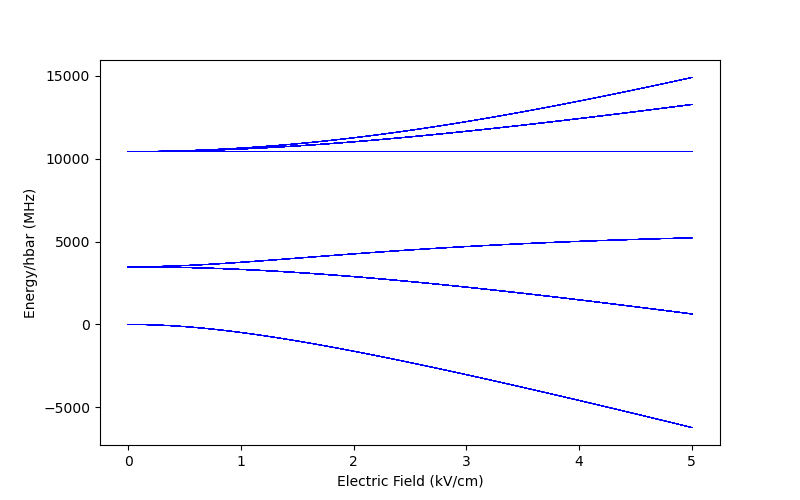

In [13]:
plt.close()

fig, ax = plt.subplots(figsize=(8, 5))
for energies in np.transpose(eigenvalues_to_plot):
    ax.plot(E_range*1e-5, energies*1e-6/h, color='b', linewidth=0.5) #, 'o', alpha = 0.5,  markersize=1)

size = len(E_range)

#ax.plot(E_range*1e-5, [Na23Cs133["Brot"]*2*1e-6/h - 10]*size, alpha = 0.5, color = "red")
#ax.plot(E_range*1e-5, [Na23Cs133["Brot"]*6*1e-6/h - 10]*size, alpha = 0.5, color = "red")

ax.set_ylabel("Energy/hbar (MHz)")
ax.set_xlabel("Electric Field (kV/cm)")